## Figure 14: 

Evolution of eddy kinetic energy differences with respect to the CRH simulation at 300 hPa for the REF simulation and simulations with CRH disabled after certain days.

---
@ Behrooz Keshtgar, KIT 2022

## 1- load python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
from matplotlib.ticker import PercentFormatter
import warnings
warnings.filterwarnings("ignore")
import colorlegend

For reference, print package versions to screen:

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib

xarrary:    0.16.0
numpy:      1.19.1
matplotlib: 3.3.0


## 2- loading datasets

In [3]:
# Dictionary for loading simulations
simdict = {
         'LC1-channel-4000x9000km-2km-0002' : {'res':'2km', 'radiation':0, 'rh':0.8}, # No radiation
         'LC1-channel-4000x9000km-2km-0003' : {'res':'2km', 'radiation':1, 'rh':0.8}, # Only cloud radiation
         'LC1-channel-4000x9000km-2km-0005' : {'res':'2km', 'radiation':1, 'rh':0.8}, # CRH disabled at day 3
         'LC1-channel-4000x9000km-2km-0006' : {'res':'2km', 'radiation':1, 'rh':0.8}, # CRH disabled at day 4
         'LC1-channel-4000x9000km-2km-0007' : {'res':'2km', 'radiation':1, 'rh':0.8}, # CRH disabled at day 5
         'LC1-channel-4000x9000km-2km-0008' : {'res':'2km', 'radiation':1, 'rh':0.8}, # CRH disabled at day 6
          }

In [4]:
# Function to load wind and surface pressure datasets

def load_simulations():
    ds_list = []
    for sim in list(simdict.keys()): 
        print('Working on loading data for', sim)
        # loading remapped datasets (0.5x0.5 r), interpolated from height to pressure levels
        path = '/work/bb1135/from_Mistral/bb1135/b381185/output/LC1_Limited_channel/icon-v.2.6.2.2_2km/sim_list_output/'+sim+'_remapped_0.5x0.5/datasets_pres/'
        # different output naming 
        if sim in ['LC1-channel-4000x9000km-2km-0002' , 'LC1-channel-4000x9000km-2km-0003']:
            fname = path+'icon-fg*.nc'
        else:
            fname = path+"icon-atm3d*.nc"                                                                              
        ds_var = xr.open_mfdataset(fname)[['u','v','pres_sfc','temp']]
        ds_list.append(ds_var)
        del fname,ds_var
    return ds_list
#----------------------------------
ds_list = load_simulations()

Working on loading data for LC1-channel-4000x9000km-2km-0002
Working on loading data for LC1-channel-4000x9000km-2km-0003
Working on loading data for LC1-channel-4000x9000km-2km-0005
Working on loading data for LC1-channel-4000x9000km-2km-0006
Working on loading data for LC1-channel-4000x9000km-2km-0007
Working on loading data for LC1-channel-4000x9000km-2km-0008


In [5]:
# make dimension names consistent
ds_list[2] = ds_list[2].rename({'plev_2': 'plev_3'})
ds_list[3] = ds_list[3].rename({'plev_2': 'plev_3'})
ds_list[4] = ds_list[4].rename({'plev_2': 'plev_3'})
ds_list[5] = ds_list[5].rename({'plev_2': 'plev_3'})

# adjusting time steps / filling the initial time steps for restart simulations with datasets from 0003 simulation
temp_1 = ds_list[1].sel(time=slice(20210101,20210104)) # sim 0004 day3
temp_2 = ds_list[1].sel(time=slice(20210101,20210105)) # sim 0007 day4
temp_3 = ds_list[1].sel(time=slice(20210101,20210106)) # sim 0008 day5
temp_4 = ds_list[1].sel(time=slice(20210101,20210107)) # sim 0010 day6

ds_list[2] = xr.merge([temp_1,ds_list[2]])
ds_list[3] = xr.merge([temp_2,ds_list[3]])
ds_list[4] = xr.merge([temp_3,ds_list[4]])
ds_list[5] = xr.merge([temp_4,ds_list[5]])

## 3- Deriving EKE at 300 and 925 hPa

In [6]:
# Function for calculating EKE at single levels

def eke_domain_mean(num,var1,var2,lev):
    # selection of pressure level and excluding north-south boundaries
    u1 = ds_list[num][var1].sel(plev_3 = lev,lat=slice(10,80),time=slice(20210104,20210110))
    v1 = ds_list[num][var2].sel(plev_3 = lev,lat=slice(10,80),time=slice(20210104,20210110))
    # zonal mean
    uzmean = u1.mean('lon',keep_attrs=True)
    vzmean = v1.mean('lon',keep_attrs=True)
    # eke
    eke = (0.5 *(np.power(u1-uzmean,2)+np.power(v1-vzmean,2)))
    # Domain mean
    ekedmean = eke.mean(dim=['lat','lon']).compute()
    return ekedmean

In [7]:
# deriving EKE at 300 and 925 hPa
eke_top = []
eke_down = []
for i in range(len(ds_list)):
    eke_300 = eke_domain_mean(i,'u','v',30000)
    eke_925 = eke_domain_mean(i,'u','v',92500)
    eke_top.append(eke_300)
    eke_down.append(eke_925)
    
    del eke_300, eke_925 

In [8]:
# EKE difference with respect to CRH simulation
diff = []
for i in range(len(ds_list)):
        tmp = eke_top[1]-eke_top[i]
        diff.append(tmp)

## 4- Plot

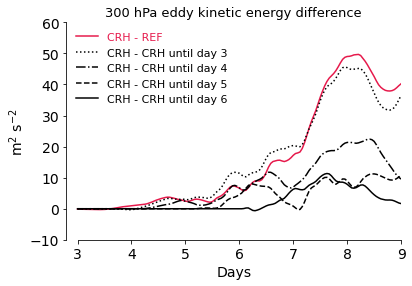

In [12]:
plt.figure(figsize=(6,4))
#----------------------------------------------------
ax=plt.subplot(1,1,1)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

plt.plot(diff[0],'#e6194B',label="CRH - REF",linewidth=1.5)
plt.plot(diff[2],'k',label="CRH - CRH until day 3",linewidth=1.5,linestyle=':')
plt.plot(diff[3],'k',label="CRH - CRH until day 4",linewidth=1.5,linestyle='-.')
plt.plot(diff[4],'k',label="CRH - CRH until day 5",linewidth=1.5,linestyle='--')
plt.plot(diff[5],'k',label="CRH - CRH until day 6",linewidth=1.5,linestyle='-')


plt.legend(prop={'size': 11},frameon=False,loc='best',labelcolor='linecolor')
#lg=colorlegend.color_legend(ax,loc='best',fsize=9)
plt.tick_params(labelsize=14)
plt.title('300 hPa eddy kinetic energy difference',fontsize=13)
plt.xlabel('Days',fontsize=14)
plt.ylabel('m$^2$ s$^{-2}$',fontsize=14)

ax.spines['bottom'].set_bounds(0,144)
ax.set_xticks(np.arange(0,168,24))
ax.set_xticklabels(["3","4","5","6","7","8","9"])
ax.set_xlim([-5, 144])

ax.spines['left'].set_bounds(-10,60)
ax.set_yticks(np.arange(-10,70,10))
ax.set_ylim([-10, 60])

plt.savefig('figure14.pdf', bbox_inches = 'tight')
#plt.savefig('figure14.png', bbox_inches = 'tight',dpi=100)